In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set(style="whitegrid")

In [2]:
# 1) Load and preprocess the dataset
df = pd.read_csv("cleaned_online_retail_data.csv")

# Drop rows with missing CustomerID or other critical values
df.dropna(subset=["Customer ID", "Invoice", "Quantity", "Price"], inplace=True)

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Calculate Revenue for each transaction
df["Revenue"] = df["Quantity"] * df["Price"]

In [3]:
# 2) Simulate session-level data
# Group transactions by Customer ID and session (using Invoice as proxy for sessions)
session_data = df.groupby(["Customer ID", "Invoice"]).agg({
    "Revenue": "sum",
    "Quantity": "sum",
    "StockCode": "count",  # proxy for items purchased
    "InvoiceDate": "min"  # timestamp of session
}).reset_index()

# Rename StockCode count to "NumItems"
session_data.rename(columns={"StockCode": "NumItems"}, inplace=True)

In [4]:
# 3) Create labels for whether a session ends in a purchase
# Here, we define 'purchase' as a session with total Revenue > 0
session_data["Purchase"] = (session_data["Revenue"] > 0).astype(int)

In [5]:
# 4) Feature engineering
# Create features such as time of day, day of week, etc.
session_data["Hour"] = session_data["InvoiceDate"].dt.hour
session_data["DayOfWeek"] = session_data["InvoiceDate"].dt.dayofweek

# Prepare the dataset for modeling
X = session_data[["Quantity", "NumItems", "Hour", "DayOfWeek"]]
y = session_data["Purchase"]

In [6]:
# 5) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 6) Train a classification model
clf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.999777183600713
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1593
           1       1.00      1.00      1.00      7383

    accuracy                           1.00      8976
   macro avg       1.00      1.00      1.00      8976
weighted avg       1.00      1.00      1.00      8976


Cross-Validation Scores: [0.99977718 0.99988858 0.99966574 0.99977716 0.99966574]
Mean CV Accuracy: 0.9997548796170784
Standard Deviation of CV Accuracy: 8.338087939888512e-05


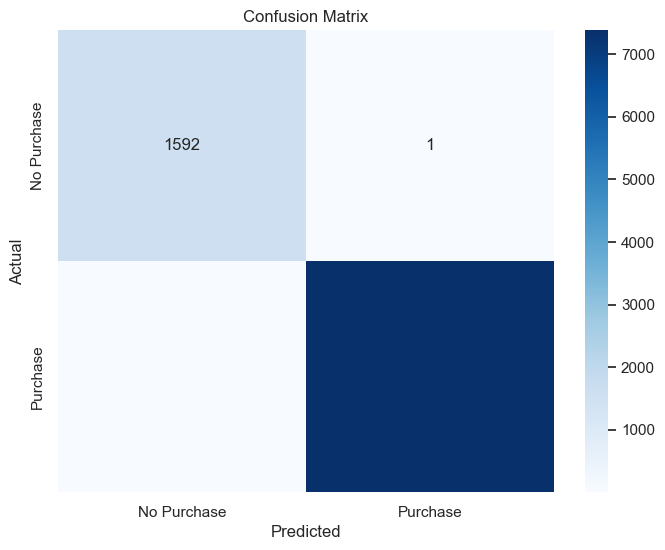

In [8]:
# 7) Evaluate the model
y_pred = clf.predict(X_test)

# Pass both y_test (true labels) and y_pred (predicted labels) to classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation of CV Accuracy:", np.std(cv_scores))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Purchase", "Purchase"], yticklabels=["No Purchase", "Purchase"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Feature Importances:
     Feature  Importance
0   Quantity    0.788658
1   NumItems    0.207462
2       Hour    0.003413
3  DayOfWeek    0.000467


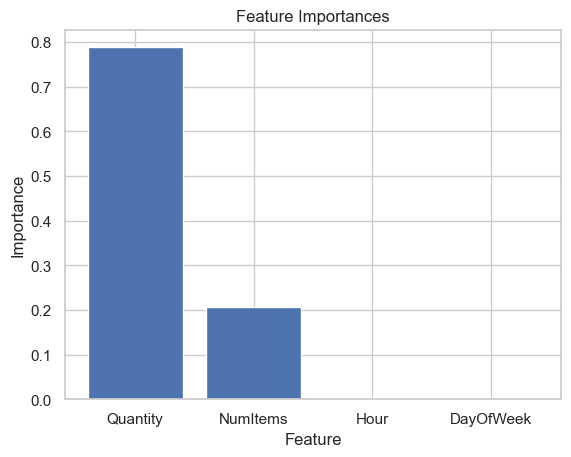


Features by Importance:
     Feature  Importance
0   Quantity    0.788658
1   NumItems    0.207462
2       Hour    0.003413
3  DayOfWeek    0.000467


In [9]:
# 8) Insights for conversion-boosting strategies
# Analyze feature importance
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display the full feature importance values
print("Feature Importances:")
print(feature_importances)

top_features = feature_importances.head(4)

plt.bar(top_features["Feature"], top_features["Importance"])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

# Print features importance values
print("\nFeatures by Importance:")
print(top_features)

Potential cart abandoners: 1592 sessions


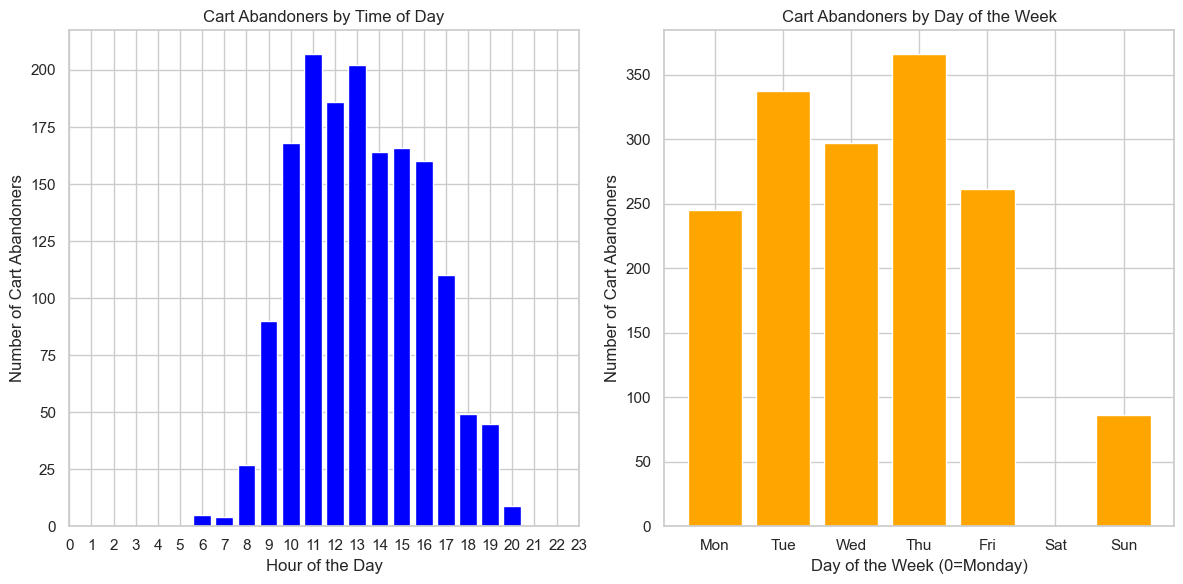


Sample of Incentives Assigned to Cart Abandoners:
       Hour  DayOfWeek  PurchaseProb                          Incentive
34842    11          4           0.0  Free Shipping - Lunchtime Special
42860    13          6           0.0  Free Shipping - Lunchtime Special
15664    12          4           0.0  Free Shipping - Lunchtime Special
14956    13          2           0.0  Free Shipping - Lunchtime Special
26834    14          3           0.0  Free Shipping - Lunchtime Special

Summary of Incentives Assigned:
Incentive
Free Shipping - Lunchtime Special    927
10% Off - Midweek Promotion          453
5% Off - Standard Offer              212
Name: count, dtype: int64


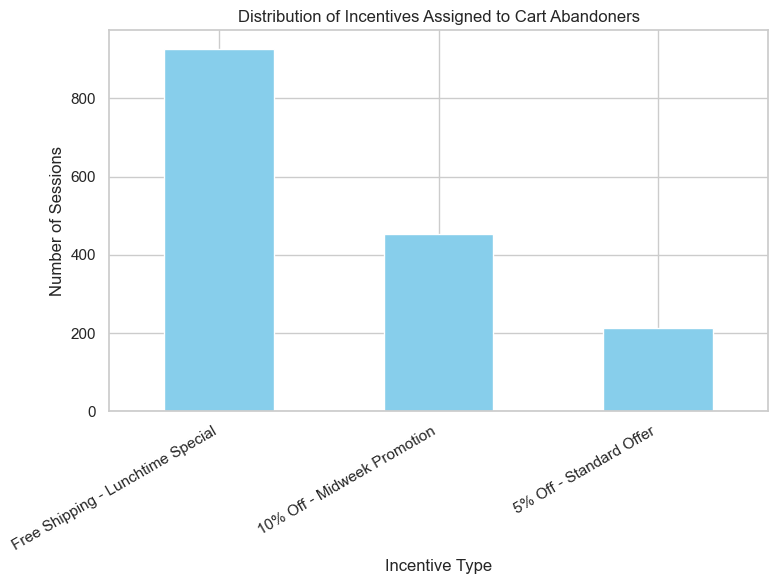

Cart Abandoners Analysis Summary:
          Quantity     NumItems         Hour    DayOfWeek  PurchaseProb  \
count  1592.000000  1592.000000  1592.000000  1592.000000   1592.000000   
mean    -25.434045     2.293342    13.211055     2.254397      0.000352   
std     156.914099     2.902134     2.777421     1.585599      0.002945   
min   -3560.000000     1.000000     6.000000     0.000000      0.000000   
25%      -9.000000     1.000000    11.000000     1.000000      0.000000   
50%      -3.000000     1.000000    13.000000     2.000000      0.000000   
75%      -1.000000     2.000000    15.000000     3.000000      0.000000   
max      -1.000000    38.000000    20.000000     6.000000      0.050000   

       ActualPurchase  
count          1592.0  
mean              0.0  
std               0.0  
min               0.0  
25%               0.0  
50%               0.0  
75%               0.0  
max               0.0  

Peak Hour of Cart Abandoners: 11
Recommendation: Offer 'Lunchtime Special

In [10]:
# 9) Recommendations
# Use the model predictions to identify sessions with a low probability of purchase
# and suggest strategies such as discounts or special offers to improve conversions

# Predict probabilities and attach to test data
predicted_probs = clf.predict_proba(X_test)[:, 1]  # Probability of Purchase=1
X_test_with_probs = X_test.copy()
X_test_with_probs["PurchaseProb"] = predicted_probs
X_test_with_probs["ActualPurchase"] = y_test.values

# Identify potential cart abandoners (e.g., low predicted probability of purchase)
cart_abandoners = X_test_with_probs[X_test_with_probs["PurchaseProb"] < 0.3]
print(f"Potential cart abandoners: {cart_abandoners.shape[0]} sessions")

# Analyze Cart Abandoners
# Group by time of day and day of the week
abandoners_by_hour = cart_abandoners.groupby("Hour").size()
abandoners_by_day = cart_abandoners.groupby("DayOfWeek").size()

# Plot insights
plt.figure(figsize=(12, 6))

# Plot cart abandoners by hour
plt.subplot(1, 2, 1)
plt.bar(abandoners_by_hour.index, abandoners_by_hour.values, color='blue')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Cart Abandoners")
plt.title("Cart Abandoners by Time of Day")
plt.xticks(ticks=range(0, 24))

# Plot cart abandoners by day
plt.subplot(1, 2, 2)
plt.bar(abandoners_by_day.index, abandoners_by_day.values, color='orange')
plt.xlabel("Day of the Week (0=Monday)")
plt.ylabel("Number of Cart Abandoners")
plt.title("Cart Abandoners by Day of the Week")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

plt.tight_layout()
plt.show()

# A) Offer special incentives to boost conversions

# Create a deep copy of cart_abandoners to avoid modifying a slice
cart_abandoners = cart_abandoners.copy()

# Assign incentives using .loc to avoid the SettingWithCopyWarning
cart_abandoners.loc[:, "Incentive"] = np.where(
    cart_abandoners["Hour"].between(10, 14), 
    "Free Shipping - Lunchtime Special", 
    np.where(
        cart_abandoners["DayOfWeek"].isin([1, 2, 3]), 
        "10% Off - Midweek Promotion", 
        "5% Off - Standard Offer"
    )
)

# Print recommended incentives for cart abandoners
print("\nSample of Incentives Assigned to Cart Abandoners:")
print(cart_abandoners[["Hour", "DayOfWeek", "PurchaseProb", "Incentive"]].head())

# Save the recommendations for targeted marketing campaigns
cart_abandoners.to_csv("cart_abandoners_with_incentives.csv", index=False)

# Summary Insights
print("\nSummary of Incentives Assigned:")
print(cart_abandoners["Incentive"].value_counts())

# Plot the distribution of assigned incentives
plt.figure(figsize=(8, 6))
cart_abandoners["Incentive"].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel("Incentive Type")
plt.ylabel("Number of Sessions")
plt.title("Distribution of Incentives Assigned to Cart Abandoners")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# B) Discount strategies for Cart Abandoners
discount_recommendations = cart_abandoners.describe()
print("Cart Abandoners Analysis Summary:")
print(discount_recommendations)

print()

# Recommend discounts
peak_hour = abandoners_by_hour.idxmax()
peak_day = abandoners_by_day.idxmax()

print(f"Peak Hour of Cart Abandoners: {peak_hour}")
# Provide recommendations based on observed peaks
if peak_hour in [10, 11, 12, 13, 14]:  # Lunchtime hours
    print("Recommendation: Offer 'Lunchtime Specials' discounts (e.g., 10% off or free shipping) to reduce cart abandonment.")
else:
    print(f"No lunchtime peak. Consider targeting {peak_hour} instead with time-based discounts.")

print()

print(f"Peak Day of Cart Abandoners: {peak_day} (0=Monday, 6=Sunday)")

if peak_day in [1, 2, 3]:  # Midweek
    print("Recommendation: Use mid-week promotions (e.g., bundle offers or time-limited discounts).")
else:
    print(f"No midweek peak. Consider targeting {['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][peak_day]} for promotions.")

# Export cart abandoners for further action
cart_abandoners.to_csv("cart_abandoners_analysis.csv", index=False)